In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import random
import torchvision.transforms as T
from glob import glob

In [2]:
folder = "/rds/general/user/mb1024/home/sigma0_arrays"
npy_files = sorted(glob(os.path.join(folder, "*.npy")))

# Load arrays
sigma0_arrays = []
for f in npy_files:
    try:
        arr = np.load(f)
        sigma0_arrays.append(arr)
    except Exception as e:
        print(f"⚠️ Skipping {f}: {e}")


⚠️ Skipping /rds/general/user/mb1024/home/sigma0_arrays/S1A_WV_SLC__1SSV_20240403T102515_20240403T103025_053268_0674D9_F586-WV_005___samp_100.npy: No data left in file
⚠️ Skipping /rds/general/user/mb1024/home/sigma0_arrays/S1A_WV_SLC__1SSV_20241013T092735_20241013T093512_056082_06DC83_8F3D-WV_003___samp_100.npy: No data left in file
⚠️ Skipping /rds/general/user/mb1024/home/sigma0_arrays/S1A_WV_SLC__1SSV_20241020T091828_20241020T092732_056184_06E08A_0A7B-WV_032___samp_100.npy: No data left in file
⚠️ Skipping /rds/general/user/mb1024/home/sigma0_arrays/S1A_WV_SLC__1SSV_20241021T095957_20241021T100537_056199_06E12C_7164-WV_006___samp_100.npy: No data left in file


In [7]:
import numpy as np
from scipy.ndimage import convolve

kernel = np.ones((3, 3))
kernel[1, 1] = 0  # exclude center pixel if you want

def fast_local_mean_fill(arr):
    nan_mask = np.isnan(arr)
    arr_copy = arr.copy()
    arr_copy[nan_mask] = 0

    local_sum = convolve(arr_copy, kernel, mode='mirror')
    local_count = convolve(~nan_mask, kernel, mode='mirror')  # count non-nans

    filled_values = np.where(local_count > 0, local_sum / local_count, np.nan)
    return np.where(nan_mask, filled_values, arr)

# Apply without loop using list comprehension (still parallelizable)
clean_sigma0_arrays = [fast_local_mean_fill(arr) for arr in sigma0_arrays]

In [8]:
print(len(clean_sigma0_arrays))

9516


In [9]:
max_height = max(arr.shape[0] for arr in clean_sigma0_arrays)
max_width = max(arr.shape[1] for arr in clean_sigma0_arrays)

In [10]:
sigma0_stack = []
for arr in clean_sigma0_arrays:
    pad_height = max_height - arr.shape[0]
    pad_width = max_width - arr.shape[1]
    
    # Pad equally on both sides
    top = pad_height // 2
    bottom = pad_height - top
    left = pad_width // 2
    right = pad_width - left
    
    padded = np.pad(
        arr,
        pad_width=((top, bottom), (left, right)),
        mode='constant',  # or 'edge', 'reflect', etc.
        constant_values=0  # or choose based on your data
    )
    sigma0_stack.append(padded)

In [112]:
class InMemoryContrastiveDataset(Dataset):
    def __init__(self, array_stack, transform=None):
        self.data = array_stack
        self.transform = transform

    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
       arr = self.data[idx].astype(np.float32)

       if np.std(arr) == 0:
           arr += np.random.normal(0, 1e-6, size=arr.shape)

    # Normalize and convert to tensor
       arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
       arr = np.expand_dims(arr, axis=0)  # shape: [1, H, W]
       img = torch.from_numpy(arr)

       if self.transform:
            aug1, aug2, original = self.transform(img)
            return aug1, aug2, original

       return img, img, img

In [35]:
import torch.nn as nn

class simple_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(32)

        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.b2 = nn.BatchNorm2d(64)

        self.c3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.b3 = nn.BatchNorm2d(128)

        self.c4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.b4 = nn.BatchNorm2d(256)

        self.c5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  # New layer
        self.b5 = nn.BatchNorm2d(512)

        self.act = nn.ReLU()

        self.p = nn.MaxPool2d(kernel_size=2, stride=2)

        self.avg = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.p(self.act(self.b1(self.c1(x))))
        x = self.p(self.act(self.b2(self.c2(x))))
        x = self.p(self.act(self.b3(self.c3(x))))
        x = self.p(self.act(self.b4(self.c4(x))))
        x = self.p(self.act(self.b5(self.c5(x))))
        x = self.avg(x)
        return x.view(x.size(0), -1)  

In [36]:
class contrastive_transforms:
    def __init__(self):
        self.transform = T.Compose([
        T.RandomRotation(degrees=45),
        T.RandomResizedCrop(190, scale=(0.8, 1.0)),
        T.GaussianBlur(kernel_size=5, sigma=(0.5, 1.5)),
        T.ColorJitter(brightness=0.4, contrast=0.4)  # vary brightness and contrast
])

    def __call__(self, x):
        return self.transform(x), self.transform(x), x

In [49]:
# --- Load Custom Dataset ---
train_dataset = InMemoryContrastiveDataset(sigma0_stack, transform=contrastive_transforms())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [20]:
# Initial SimCLR model placeholder
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=512):
        super().__init__()
        self.encoder = base_encoder
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        z = F.normalize(z, dim=1, eps=1e-8)
        return z

In [21]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2B, D]
    z = F.normalize(z, dim=1)  # Safer: remove noise for now

    # Cosine similarity matrix
    similarity_matrix = torch.matmul(z, z.T) / temperature  # [2B, 2B]

    # Remove self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))  # safer than -9e15

    # Positive pair indices
    labels = torch.arange(batch_size, device=z.device)
    labels = torch.cat([labels + batch_size, labels])

    # Logits
    logits = torch.clamp(similarity_matrix, min=-50.0, max=50.0)  # prevent overflow
    loss = -F.log_softmax(logits, dim=1)[torch.arange(2 * batch_size), labels].mean()

    return loss
    

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(simple_cnn()).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
def train_contrastive(model, train_loader, optimizer, epochs=20, device="cuda"):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for x_i, x_j, _ in train_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)
            z_i = model(x_i)
            z_j = model(x_j)

            if torch.isnan(z_i).any() or torch.isnan(z_j).any():
                continue

            loss = nt_xent_loss(z_i, z_j, temperature=0.4)
            if torch.isnan(loss):
                continue

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f}")
    
    return loss_history

In [57]:
loss_history = train_contrastive(model, train_loader, optimizer, epochs=10)
loss_curves[name] = loss_history

# === STEP 6: Plot loss curves ===
for name, losses in loss_curves.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Loss Comparison Across Augmentations")
plt.legend()
plt.grid()
plt.show()

Epoch [1/10] | Loss: 3.5075
Epoch [2/10] | Loss: 3.3207
Epoch [3/10] | Loss: 3.1191
Epoch [4/10] | Loss: 2.9110
Epoch [5/10] | Loss: 2.7593
Epoch [6/10] | Loss: 2.6986
Epoch [7/10] | Loss: 2.6055
Epoch [8/10] | Loss: 2.5165
Epoch [9/10] | Loss: 2.4502
Epoch [10/10] | Loss: 2.4009


NameError: name 'loss_curves' is not defined

In [ ]:
loss_curves[name] = loss_history
# === STEP 6: Plot loss curves ===
for name, losses in loss_curves.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Loss Comparison Across Augmentations")
plt.legend()
plt.grid()
plt.show()

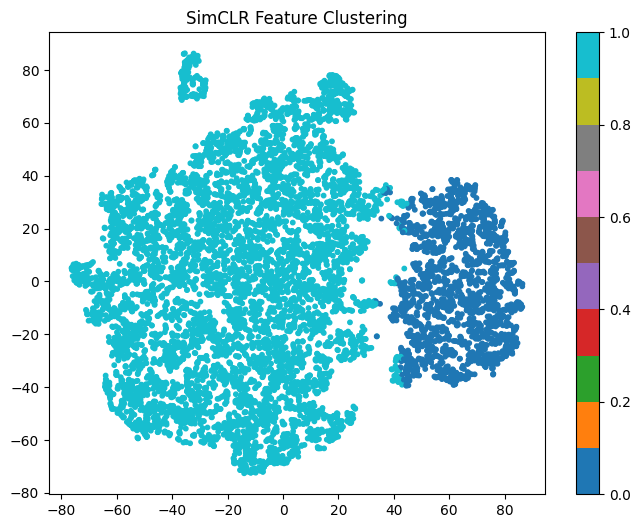

In [63]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# === CONFIG ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_clusters = 2  # Set this based on how many groups you expect

# === STEP 1: Extract Features ===
def extract_features(encoder, train_loader):
    encoder.eval()
    all_features = []
    all_originals = []
    with torch.no_grad():
        for x_i, _, originals in train_loader:  # grab original image from dataset
            x_i = x_i.to(device)
            feats = encoder(x_i)
            all_features.append(feats.cpu())
            all_originals.extend(originals)  # keep originals
    return torch.cat(all_features, dim=0).numpy(), all_originals


# === STEP 2: Dimensionality Reduction ===
def reduce_dimensionality(features, n_pca=50):
    features = features[~np.isnan(features).any(axis=1)]
    pca = PCA(n_components=n_pca)
    return pca.fit_transform(features)

# === STEP 3: KMeans Clustering ===
def cluster_features(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_ids = kmeans.fit_predict(features)
    return cluster_ids

# === STEP 4: Visualization with t-SNE ===
def visualize_clusters(features, cluster_ids, title="t-SNE Clustering"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embedded = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded[:, 0], embedded[:, 1], c=cluster_ids, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

# === USAGE ===
features, original_images = extract_features(model.encoder, train_loader)

# Optional PCA before KMeans and t-SNE
reduced_features = reduce_dimensionality(features, n_pca=50)

# Clustering
cluster_ids = cluster_features(reduced_features, num_clusters)

# Visualize
visualize_clusters(reduced_features, cluster_ids, title="SimCLR Feature Clustering")

In [64]:
from collections import defaultdict

# Create a mapping from cluster id to original images
cluster_to_images = defaultdict(list)
for img, cluster_id in zip(original_images, cluster_ids):
    cluster_to_images[cluster_id].append(img)

In [65]:
def show_cluster_samples(cluster_to_images, max_images=25, grid_cols=5):
    num_clusters = len(cluster_to_images)
    grid_rows = max_images // grid_cols

    plt.figure(figsize=(grid_cols * 2, num_clusters * grid_rows * 2))

    for row_idx, (cluster_id, images) in enumerate(cluster_to_images.items()):
        for i in range(min(max_images, len(images))):
            r = i // grid_cols
            c = i % grid_cols
            plt_idx = row_idx * grid_rows * grid_cols + r * grid_cols + c + 1

            plt.subplot(num_clusters * grid_rows, grid_cols, plt_idx)

            img = images[i]
            if isinstance(img, torch.Tensor):
                img = img.squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            # Label cluster on the first image in each row
            if r == 0 and c == 0:
                plt.title(f"Cluster {cluster_id}", fontsize=10)

    plt.tight_layout()
    plt.show()

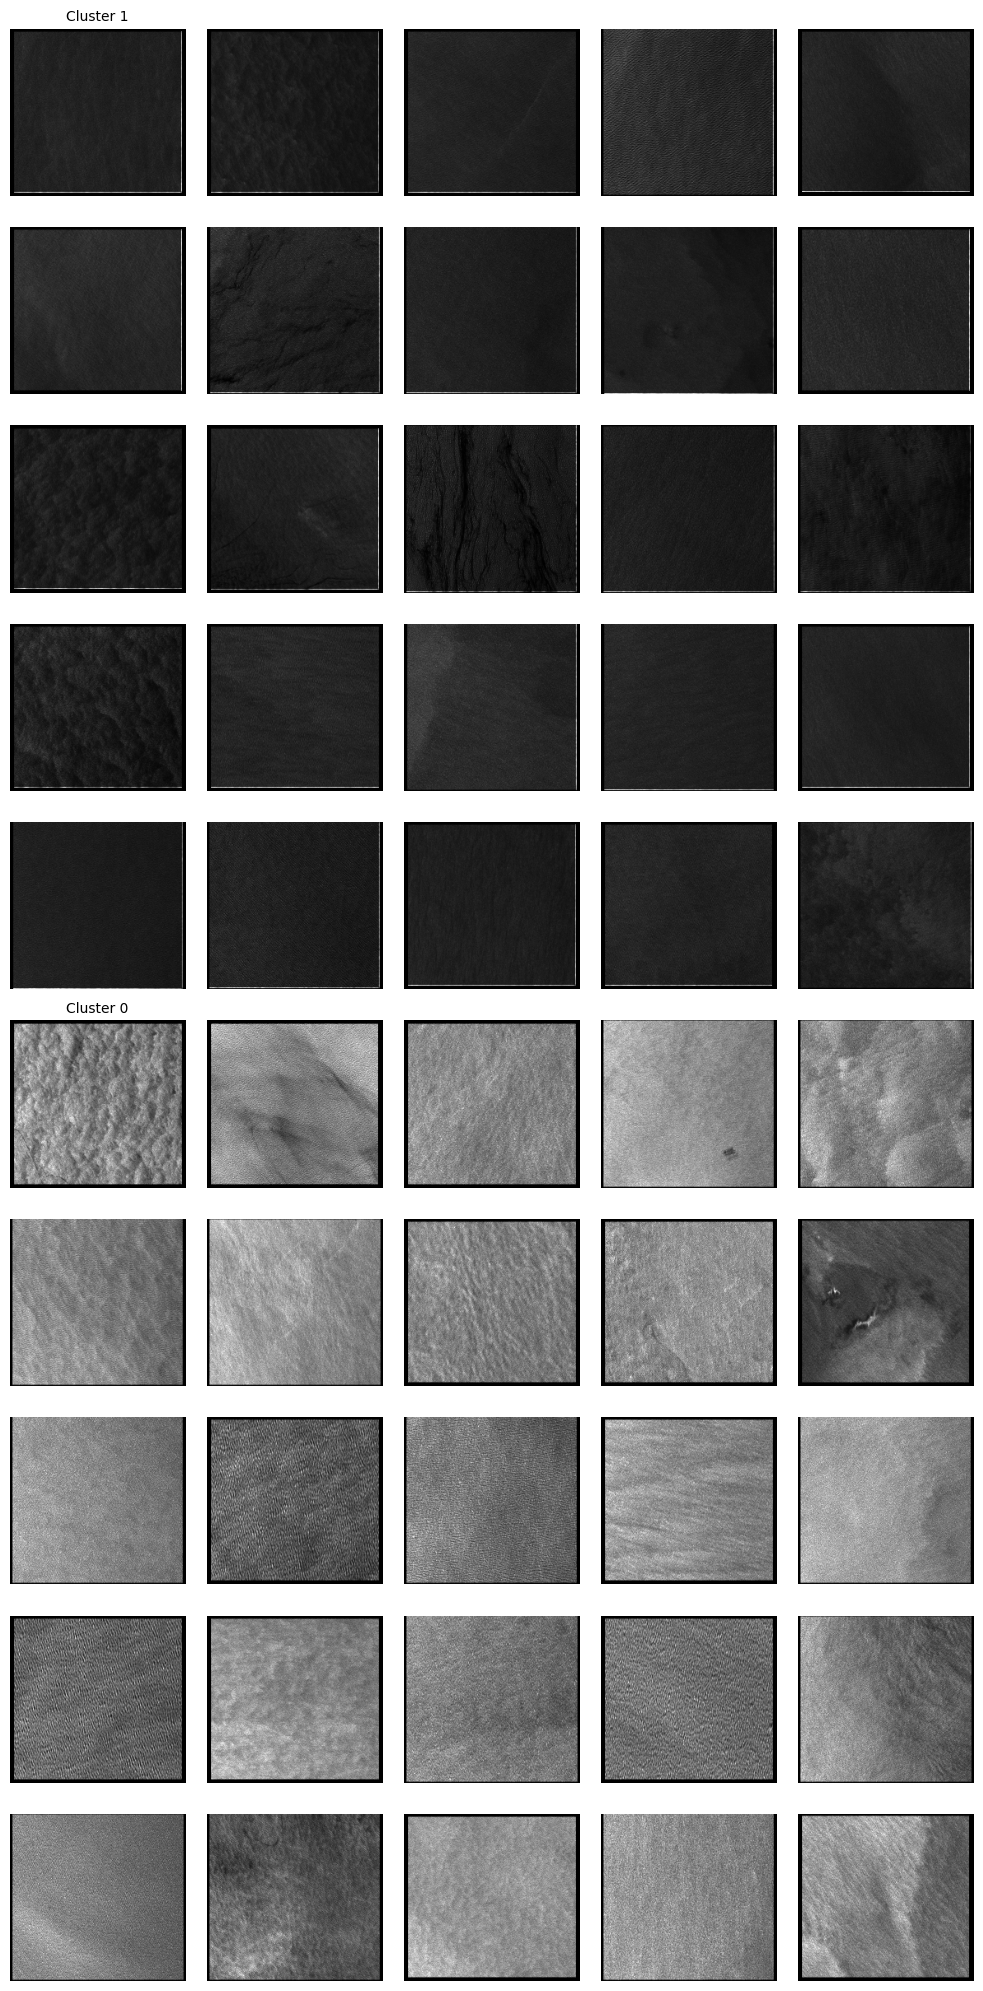

In [66]:
show_cluster_samples(cluster_to_images, max_images=25, grid_cols=5)

In [75]:
# get images from cluster 0
cluster0_images = cluster_to_images[0]
cluster1_images = cluster_to_images[1]


In [70]:
cluster0_images_array = np.stack(cluster0_images)
cluster0_dataset = InMemoryContrastiveDataset(cluster0_images_array, transform=contrastive_transforms())
cluster0_loader = DataLoader(cluster0_dataset, batch_size=32, shuffle=True)

In [72]:
print(len(cluster0_images))

2061


In [103]:
print(len(cluster1_images))

7455


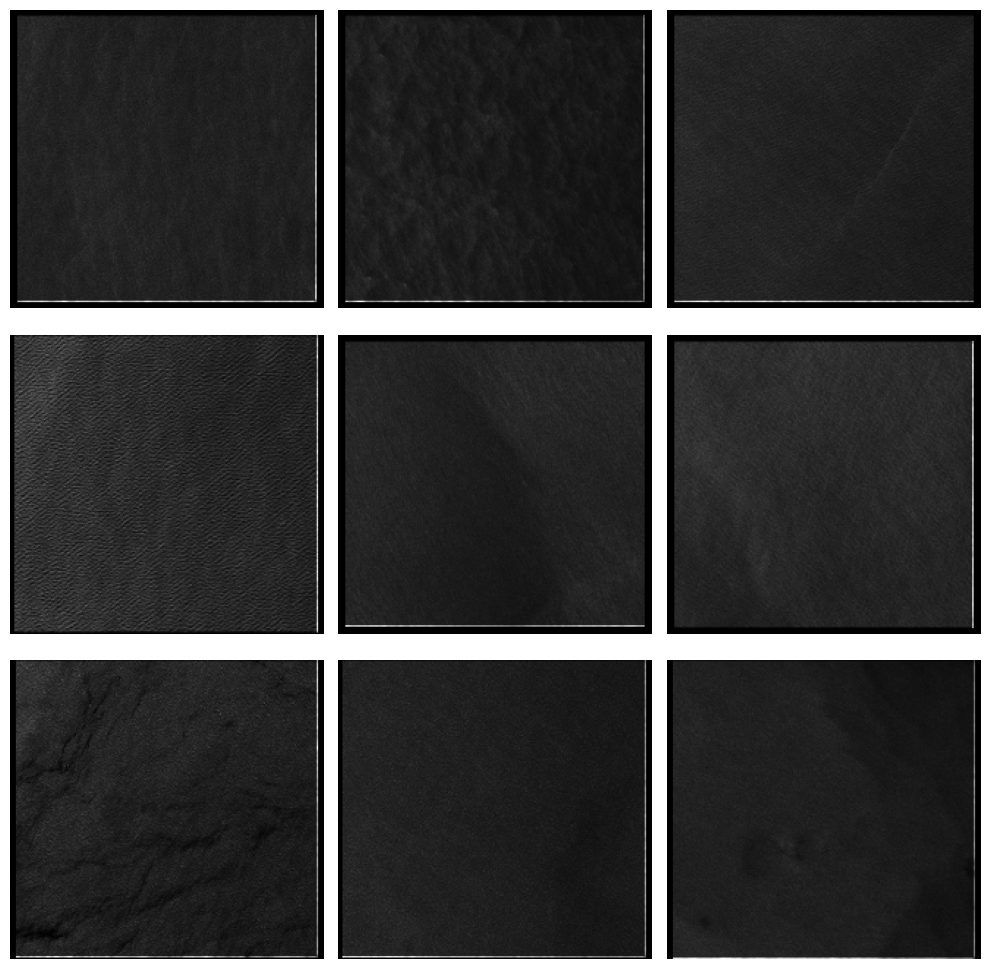

In [87]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = cluster1_images[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

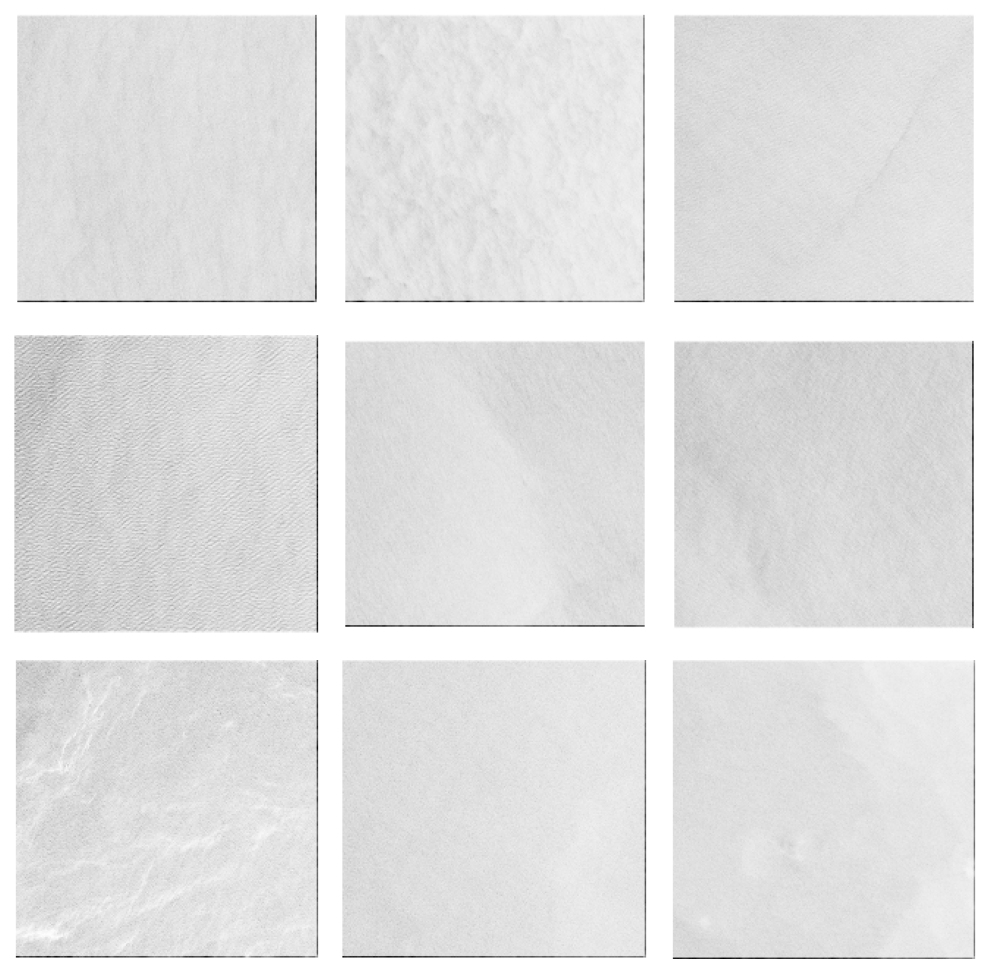

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(9):
    img = cluster1_images[i].squeeze()
    inverted = 1.0 - img

    plt.subplot(3, 3, i+1)
    plt.imshow(inverted, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [171]:
cluster1_images_inv = [1 - img for img in cluster1_images]

In [172]:
cluster_inv5 = cluster1_images_inv + cluster0_images

In [173]:
cluster_inv5 = torch.stack(cluster_inv5)


In [ ]:
cluster_images = cluster0_images + cluster1_images

In [161]:
inverted_images = [1 - img for img in cluster_images]

In [162]:
print(len(inverted_images))

9516


In [163]:
inverted_images = torch.stack(inverted_images)

In [159]:
print(type(inverted_images[0]))
print(inverted_images[0])

<class 'numpy.int32'>
1


In [143]:
print(inverted_images.dtype)

torch.float32


In [ ]:
class contrastive_transforms:
    def __init__(self):
        self.transform = T.Compose([
        T.RandomRotation(degrees=45),
        T.RandomResizedCrop(190, scale=(0.8, 1.0)),
        T.GaussianBlur(kernel_size=5, sigma=(0.5, 1.5))
          # vary brightness and contrast
])

    def __call__(self, x):
        return self.transform(x), self.transform(x), x

In [164]:
class InMemoryContrastiveDataset(Dataset):
    def __init__(self, array_stack, transform=None):
        self.data = array_stack
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get array (torch or numpy)
        arr = self.data[idx]
        
        # if array is numpy, convert to float32
        if isinstance(arr, np.ndarray):
            arr = arr.astype(np.float32)
            arr = torch.from_numpy(arr)
        else:
            arr = arr.float()

        # check constant values
        if torch.std(arr) == 0:
            arr += torch.randn_like(arr) * 1e-6

        # min-max normalize
        arr_min = arr.min()
        arr_max = arr.max()
        arr = (arr - arr_min) / (arr_max - arr_min + 1e-8)

        # add channel dimension if needed
        if arr.ndim == 2:
            arr = arr.unsqueeze(0)   # [1, H, W]

        img = arr  # [1,H,W]

        if self.transform:
            aug1, aug2, original = self.transform(img)
            return aug1, aug2, original

        return img, img, img


In [174]:
train_dataset = InMemoryContrastiveDataset(cluster_inv5, transform=contrastive_transforms())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [175]:
cnn = simple_cnn()

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(simple_cnn()).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_history = train_contrastive(model, train_loader, optimizer, epochs=20)
loss_curves[name] = loss_history

# === STEP 6: Plot loss curves ===
for name, losses in loss_curves.items():
    plt.plot(losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Loss Comparison Across Augmentations")
plt.legend()
plt.grid()
plt.show()

Epoch [1/20] | Loss: 2.2723


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# === CONFIG ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_clusters = 6  # Set this based on how many groups you expect

# === STEP 1: Extract Features ===
def extract_features(encoder, train_loader):
    encoder.eval()
    all_features = []
    all_originals = []
    with torch.no_grad():
        for x_i, _, originals in train_loader:  # grab original image from dataset
            x_i = x_i.to(device)
            feats = encoder(x_i)
            all_features.append(feats.cpu())
            all_originals.extend(originals)  # keep originals
    return torch.cat(all_features, dim=0).numpy(), all_originals


# === STEP 2: Dimensionality Reduction ===
def reduce_dimensionality(features, n_pca=50):
    features = features[~np.isnan(features).any(axis=1)]
    pca = PCA(n_components=n_pca)
    return pca.fit_transform(features)

# === STEP 3: KMeans Clustering ===
def cluster_features(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_ids = kmeans.fit_predict(features)
    return cluster_ids

# === STEP 4: Visualization with t-SNE ===
def visualize_clusters(features, cluster_ids, title="t-SNE Clustering"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embedded = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded[:, 0], embedded[:, 1], c=cluster_ids, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

# === USAGE ===
features, original_images = extract_features(model.encoder, train_loader)

# Optional PCA before KMeans and t-SNE
reduced_features = reduce_dimensionality(features, n_pca=50)

# Clustering
cluster_ids = cluster_features(reduced_features, num_clusters)

# Visualize
visualize_clusters(reduced_features, cluster_ids, title="SimCLR Feature Clustering")

In [ ]:
from collections import defaultdict

# Create a mapping from cluster id to original images
cluster_to_images = defaultdict(list)
for img, cluster_id in zip(original_images, cluster_ids):
    cluster_to_images[cluster_id].append(img)

In [ ]:
def show_cluster_samples(cluster_to_images, max_images=25, grid_cols=5):
    num_clusters = len(cluster_to_images)
    grid_rows = max_images // grid_cols

    plt.figure(figsize=(grid_cols * 2, num_clusters * grid_rows * 2))

    for row_idx, (cluster_id, images) in enumerate(cluster_to_images.items()):
        for i in range(min(max_images, len(images))):
            r = i // grid_cols
            c = i % grid_cols
            plt_idx = row_idx * grid_rows * grid_cols + r * grid_cols + c + 1

            plt.subplot(num_clusters * grid_rows, grid_cols, plt_idx)

            img = images[i]
            if isinstance(img, torch.Tensor):
                img = img.squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            # Label cluster on the first image in each row
            if r == 0 and c == 0:
                plt.title(f"Cluster {cluster_id}", fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
show_cluster_samples(cluster_to_images, max_images=25, grid_cols=5)